# Developing Model Agnostic Tools 

This notebook runs through the development of two agnostic tools of interest for model selection based on a desired data metric.<br><br>
**1. Lookup Warming Level and Year Tool**: This tool illustrates the on-going development of functionality to identify either a **warming level** or a **year** of interest, based on a given scenario. This tool ties warming levels, climate scenarios, and year together for a specific location that may be of interest to stakeholders for their planning needs.<br><br>*Intended Application*: As a utility analyst, I want to be able to enter either a warming level or year of interest, and extract information on the model distribution at that warming level or year for my analysis needs. <br><br>
**2. WRF/LOCA Simulation Explorer Tool**: This tool illustrates the on-going development of functionality to identify the WRF or LOCA simulations that match a pre-selected list of statistics for a metric, namely the min, max, quartiles, and middle 10% of models. <br><br>*Intended Application*: As a policy-maker exploring future projects, I want to understand the landscape of WRF or LOCA runs in order to utilize a range of projections in my decision-making. 

## Step 0: Setup 

In [25]:
from climakitae.explore.agnostic import (
    create_lookup_tables,
    create_conversion_function,
    agg_area_subset_sims, 
    agg_lat_lon_sims, 
    plot_sims,
    plot_WRF
)

## Tool 1: Lookup Warming Level and Year

This tool is designed to provide critical information on the connections between global warming levels, scenario, and timing amongst model simulations. We utilize SSP3-7.0 here as the climate scenario. The handy `find_warm_level_or_time` function will return either the `warming_level` or `year` of interest based on the inputs and is completely flexible for input needs. Warming levels are constrained to 1.5°C, 2.0°C, and 3°C, as only a portion of model simulations do not reach 4°C warming to provide statistical confidence in the results. 

### Step 1: Create the model lookup tables
The `find_warm_level_or_time` function is built off of look-up tables for all simulations and their designated warming levels based on the 1850-1900 historical baseline as is standard in the global warming levels approach. First we need to generate the lookup tables that this function utilizes. 

In [ ]:
lookup_tables = create_lookup_tables()
find_warm_level_or_time = create_conversion_function(lookup_tables)

### Step 2: Example usage of the Lookup Function for Identifying a Year

In the following cells, we demonstrate how to find the year and month of interest when a **warming level** is passed as input to the tool, and returns several key pieces of information based on SSP3-7.0 as the climate scenario:
- A histogram of all 80 simulations binned by when the simulation reaches the input warming level
- Median year, and the specific year-month

In [ ]:
find_warm_level_or_time(warming_level='1.5')

In [ ]:
find_warm_level_or_time(warming_level='2.0')

In [ ]:
find_warm_level_or_time(warming_level='3.0')

### Step 3: Example usage of the Lookup Tool to find the projected warming level

In the following cells, we demonstrate how to find the warming level interest when a **year** is passed as input to the tool, and returns several key pieces of information based on SSP3-7.0 as the climate scenario:
- A histogram of all 80 simulations binned by warming level
- The major warming level nearest to the median projected warming level
- Information on the median projected warming level

In [ ]:
find_warm_level_or_time(year=2043)

In [ ]:
find_warm_level_or_time(year=2050)

In [ ]:
find_warm_level_or_time(year=2070)

In [ ]:
find_warm_level_or_time(year=2100)

## Tool 2: Simulation Explorer Tool

Now we demonstrate the on-going development of the Simulation Explorer tool. Given a specific location and pre-calculated metric of interest, this tool returns information on the statistical distribution of simulations based on the selected metric for suitability in planning design. 

Current metrics include: Average Maximum Air Temperature (2030-2059), Average Minimum Air Temperature (2030-2059), Average Maximum Relative Humidity (2030-2059), and Average Annual Total Precipitation (2030-2059). More metrics, and customization of metrics, is forthcoming. 

### Step 1: Identify parameters and location of interest

At present, there are 4 available metrics to explore the distribution amongst LOCA or WRF simulations. Below are the listed names for these metrics that you can input in the following cell:

**Metrics:**
- `Average Max Air Temperature`
- `Average Min Air Temperature`
- `Average Max Relative Humidity`
- `Average Annual Total Precipitation`

We'll utilize `Average Max Air Temperature` in our examples below.

In [2]:
### Change these parameters to your choosing

# Months desired for analysis, Jan = 1
months = [4, 5, 7]

# Years desired for analysis, inclusive
years = (2030, 2059)

# Change this metric to one of the above that you'd like
metric = "Average Annual Total Precipitation"

# Change this method to describe if you'd like to examine LOCA or WRF simulations
method = 'WRF'

### Step 2: Run analyses

With the below function, we can look at the distribution of either LOCA or WRF simulations for a gridcell at a specific lat/lon. This will take a couple minutes to calculate all the aggregations. Hang tight!

In [3]:
%%time
single_stats_gridcell, multiple_stats_gridcell, results_gridcell = agg_lat_lon_sims(32.8812, -117.2344, metric, years, method, months)


Input coordinates: (32.88, -117.23)
Nearest grid cell coordinates: (32.89, -117.23)
CPU times: user 9.03 s, sys: 3.23 s, total: 12.3 s
Wall time: 16.2 s


With this below function, we can look at the distribution of simulations across a selected metric for the SCE service territory. This calculation will take longer, since it will compute across a much larger area (~10 min). Run the cell, go refill some water, take a break, and come back in about 10 minutes.

In [ ]:
%%time
single_stats_area, multiple_stats_area, results_area = agg_area_subset_sims("CA Electric Load Serving Entities (IOU & POU)", 'Southern California Edison', metric, years, method, months)

### Step 3: Extract simulations based on specific statistics.
Below we illustrate how to retrieve simulations on the min, max, 25th and 75th quartiles, and the middle 10% of the distribution.

In [ ]:
min_sim = single_stats_gridcell['min']
min_sim

In [ ]:
q1_sim = single_stats_gridcell['q1']
q1_sim

In [ ]:
med_sim = single_stats_gridcell['median']
med_sim

In [ ]:
q3_sim = single_stats_gridcell['q3']
q3_sim

In [ ]:
max_sim = single_stats_gridcell['max']
max_sim

In [ ]:
# Finding statistics that return multiple simulations
mid_10 = multiple_stats_gridcell['middle 10%']
mid_10

### Step 4: Visualize the distribution of results

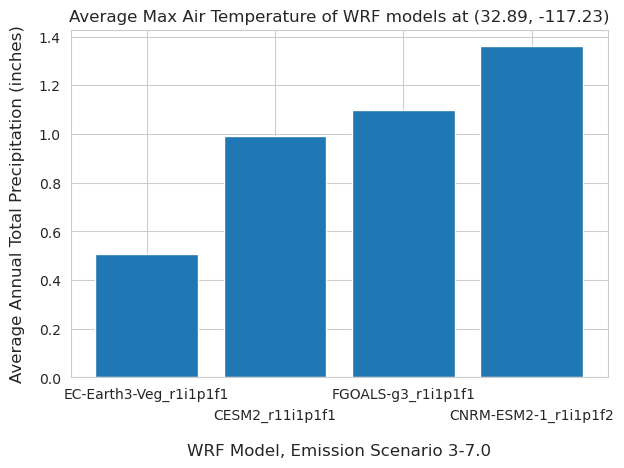

In [28]:
# Plotting distribution of simulations based on if your method was 'WRF' or 'LOCA'.
if method == 'WRF':
    plot_WRF(results_gridcell, metric)
elif method == 'LOCA':
    plot_sims(results_area, metric, years, single_stats_area)